# Setup

## Import Libraries

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from matplotlib import style
import cv2
import glob
import os
from collections import deque
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline



## Initialize Constants

In [2]:
img = cv2.imread('./camera_cal/calibration1.jpg')
camera_y, camera_x, camera_d = img.shape
img_size = (camera_x, camera_y)

#corners
# vertical corners
corners_y = 6
# horizontal corners
corners_x = 9
pattern = (corners_x,corners_y)

dpi = 80
xpixels = camera_y/dpi
ypixels = camera_x/dpi
large = (xpixels,ypixels)
medium = (xpixels/2,ypixels/2)
small = (xpixels/4,ypixels/4)

## Helper Functions

In [3]:
def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

In [4]:
# convert cv2 BGR to GRAY
def BGR2GRAY(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [5]:
# for plt.show() or plt.imshow()
def BGR2RGB(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [6]:
# plot BGR image from cv2 using matplotlib
# resize figure
def plot_image_BGR(img,size=100):
    y, x, d = img.shape
    fig = plt.figure(figsize=(x/size, y/size))
    global fig
    plt.imshow(BGR2RGB(img))
    plt.axis('off')

In [7]:
# plot BGR image from cv2 using matplotlib
# resize figure
def plot_image_GRAY(gray,size=100):
    y, x = gray.shape
    fig = plt.figure(figsize=(x/size, y/size))
    global fig
    plt.imshow(gray,cmap='gray')
    plt.axis('off')

In [8]:
# for plt.show() or plt.imshow()
def HLS2BGR(img):
    return cv2.cvtColor(img, cv2.COLOR_HLS2BGR)

# 1. Camera Calibration

### Process each Chessboard Image find Calibration Parameters 

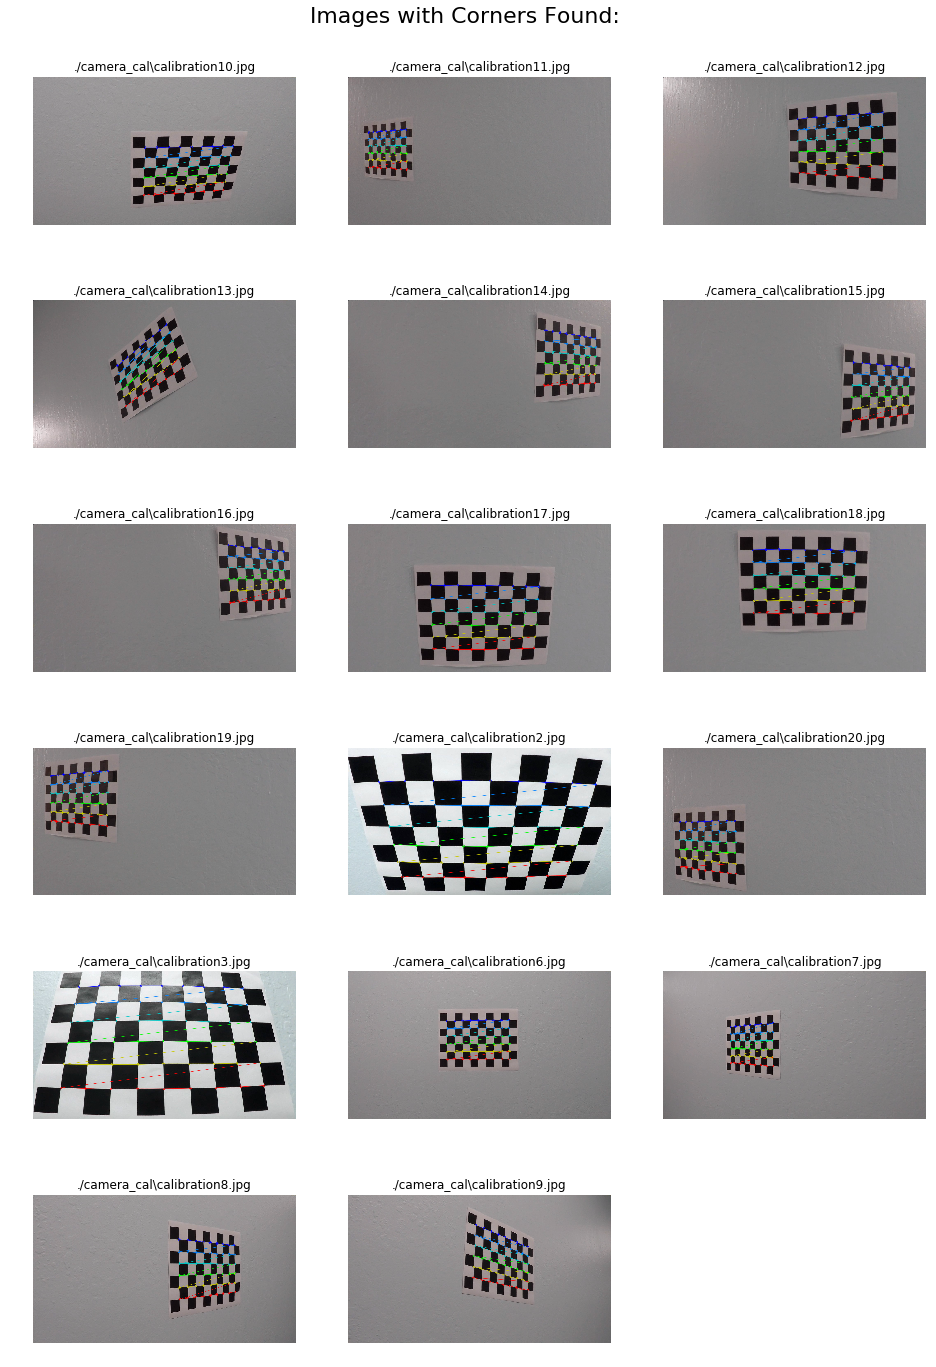

In [9]:
objp = np.zeros((corners_y*corners_x,3), np.float32)
objp[:,:2] = np.mgrid[0:corners_x, 0:corners_y].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.
images = glob.glob('./camera_cal/calibration*.jpg') # Make a list of paths to calibration images
# Step through the list and search for chessboard corners
corners_not_found = [] #Calibration images in which opencv failed to find corners
f = plt.figure(figsize=(16, 24)) #Figure for calibration images
plt.figtext(0.5,0.9,'Images with Corners Found:', fontsize=22, ha='center')
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = BGR2GRAY(img) # Conver to grayscale
    ret, corners = cv2.findChessboardCorners(gray, pattern, None) # Find the chessboard corners
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        plt.subplot(6, 3, len(imgpoints))
        cv2.drawChessboardCorners(img, pattern, corners, ret)
        plt.imshow(img)
        plt.title(fname)
        plt.axis('off')
    else:
        corners_not_found.append(fname)
plt.show()
f.savefig("./output_images/corners_found.jpg")

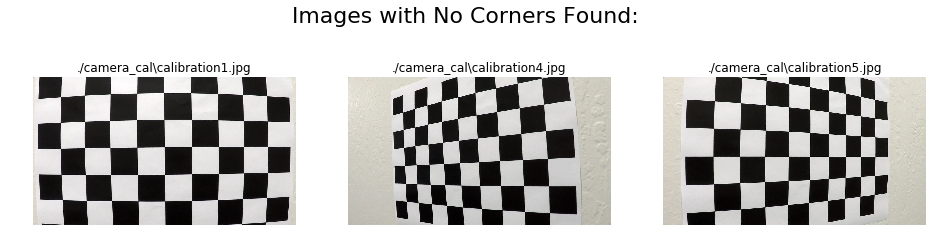

In [10]:
# Draw pictures
f = plt.figure(figsize=(16, 6))
plt.figtext(.5,.8,'Images with No Corners Found:', fontsize=22, ha='center')
for i, p in enumerate(corners_not_found):
    plt.subplot(1, 3, i+1)
    plt.imshow(mpimg.imread(p)) #draw the first image of each class
    plt.title(p)
    plt.axis('off')
plt.show()
f.savefig("output_images/corners_not_found.jpg")

### Use Parameters to Calibrate Camera

In [11]:
# mtx - camera matrix - 3D to 2D
# dist - distortion coefficient
# rvecs - rotation vector
# tvecs - translation vector
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

### Confirm Distortion Correction on Camera Images

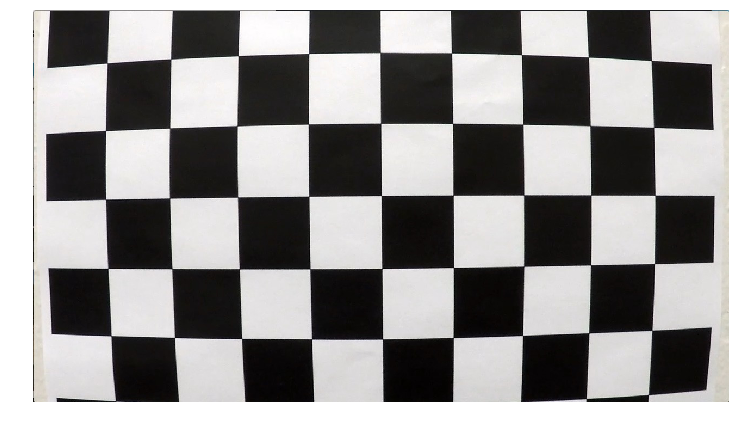

In [12]:

img = cv2.imread('./camera_cal/calibration1.jpg')
plot_image_BGR(img)

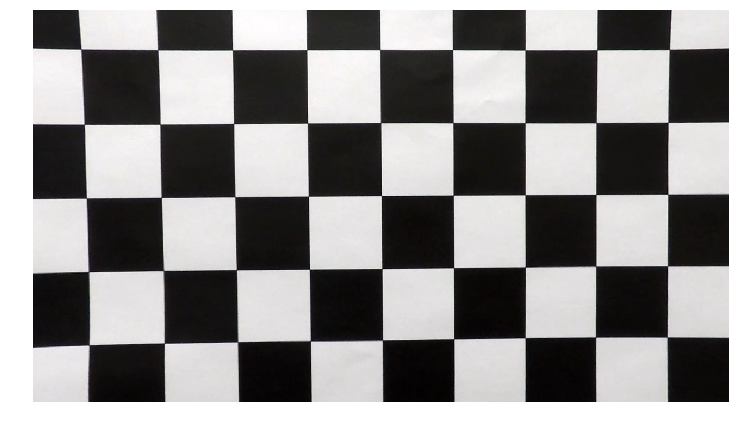

In [13]:
plot_image_BGR(undistort(img))
fig.savefig("output_images/calibration1_undist.jpg")

### Confirm Distortion Correction on Test Images

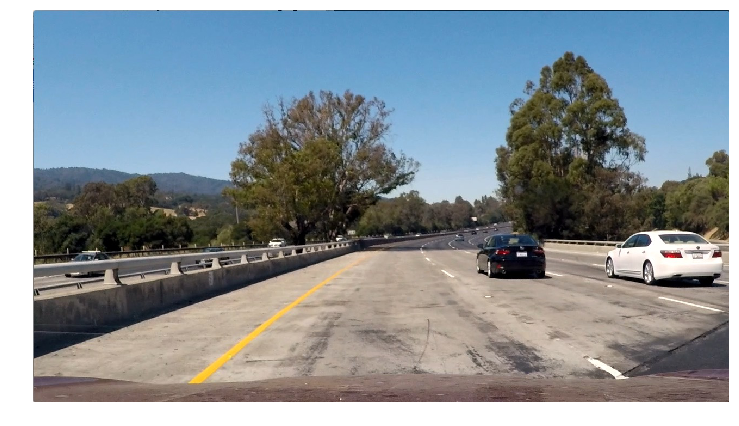

In [14]:
img = cv2.imread('./test_images/test1.jpg')
plot_image_BGR(img)

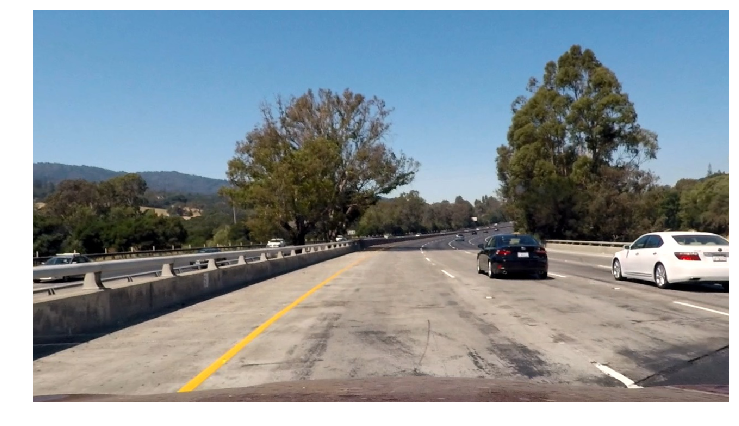

In [15]:
plot_image_BGR(undistort(img))
fig.savefig("output_images/test1_undist.jpg")

# 2. Create Thresholded Binary  Image

## Create Thresholding Helper Functions

In [16]:
def binary_thresh(channel,thresh):
    binary = np.zeros_like(channel)
    binary[(channel > thresh[0]) & (channel <= thresh[1])] = 1
    return binary

# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
# used in this project in x direction, OK at low levels
def abs_sobel_thresh(img, orient='x', thresh=(0, 255)):
    gray = BGR2GRAY(img)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = binary_thresh(scaled_sobel,thresh)
    # Return the result
    return binary_output

# Magnitude thresholding
# not used, too noisy
def mag_thresh(img, ksize=3, thresh=(0, 255)):
    gray = BGR2GRAY(img)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=ksize)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=ksize)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    binary_output = binary_thresh(gradmag,thresh)
    return binary_output

# Directional Thresholding
# not used, too noisy
def dir_thresh(img, ksize=3, thresh=(0.*np.pi, 0.5*np.pi)):
    gray = BGR2GRAY(img)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=ksize)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=ksize)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output = binary_thresh(absgraddir,thresh)
    return binary_output

# Histogram normalization
# not used
def eq_Hist(img): # Histogram normalization
    eq = np.copy(img)
    eq[:, :, 0] = cv2.equalizeHist(img[:, :, 0])
    eq[:, :, 1] = cv2.equalizeHist(img[:, :, 1])
    eq[:, :, 2] = cv2.equalizeHist(img[:, :, 2])
    return eq

# Binary saturation channel threshold
# not used
def HLS_thresh(img, h_thresh=(0, 255), l_thresh=(0, 255), s_thresh=(0, 255) ):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    binary_h = binary_thresh(h_channel,h_thresh)
    binary_l = binary_thresh(l_channel,l_thresh)
    binary_s = binary_thresh(s_channel,s_thresh)
    
    binary_output = np.zeros_like(s_channel)
    binary_output[(binary_h==1) & (binary_l==1) & (binary_s==1)] = 1
    
    return binary_output

# Hue Saturation Value
# used to find yellow and white color from lanes
# most useful threshold
def HSV_thresh(img, h_thresh=(0, 255), s_thresh=(0, 255), v_thresh=(0, 255) ):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h_channel = hsv[:,:,0]
    s_channel = hsv[:,:,1]
    v_channel = hsv[:,:,2]
    
    binary_h = binary_thresh(h_channel,h_thresh)
    binary_s = binary_thresh(s_channel,s_thresh)
    binary_v = binary_thresh(v_channel,v_thresh)
    
    binary_output = np.zeros_like(s_channel)
    binary_output[(binary_h==1) & (binary_s==1) & (binary_v==1)] = 1
    
    return binary_output

# Binary saturation channel threshold
# not used
def BGR_thresh(img, b_thresh=(0, 255), g_thresh=(0, 255), r_thresh=(0, 255) ):
    b_channel = img[:,:,0]
    g_channel = img[:,:,1]
    r_channel = img[:,:,2]
    
    binary_b = binary_thresh(b_channel,b_thresh)
    binary_g = binary_thresh(g_channel,g_thresh)
    binary_r = binary_thresh(r_channel,r_thresh)
    
    binary_output = np.zeros_like(b_channel)
    binary_output[(binary_b==1) & (binary_g==1) & (binary_r==1)] = 1
    
    return binary_output

## Combined Thresholding

A combination of HSV and x sobel thresholding worked best to find lines in the video. HSV worked best. I created threshold values for white and yellow lane lines seperately. I then used a binary or operator to combine the 2 thresholds to find both white and yellow lane lines. Sobel x was worked better than other sobel derivatives but was more noisy than using color alone. However, I found that I needed it because using color alone wasn't robust enough for the video.

In [17]:
def thresh_ywx_bgr(img):
    yh_thresh = (0,40)
    ys_thresh = (80,255)
    yv_thresh = (200,255)
    wh_thresh = (0,30)
    ws_thresh = (0,30)
    wv_thresh = (200,255)
    x_thresh = (20,25)
    
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    gray = BGR2GRAY(img)
    
    h_channel = hsv[:,:,0]
    s_channel = hsv[:,:,1]
    v_channel = hsv[:,:,2]
    
    abs_sobel_x = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    
    # scaling
    scaled_sobel = np.uint8(255*abs_sobel_x/np.max(abs_sobel_x))
    
    binary_x = binary_thresh(scaled_sobel,x_thresh)
    
    binary_yh = binary_thresh(h_channel,yh_thresh)
    binary_ys = binary_thresh(s_channel,ys_thresh)
    binary_yv = binary_thresh(v_channel,yv_thresh)

    binary_wh = binary_thresh(h_channel,wh_thresh)
    binary_ws = binary_thresh(s_channel,ws_thresh)
    binary_wv = binary_thresh(v_channel,wv_thresh)
    
    binary_y = np.zeros_like(s_channel)
    binary_w = np.zeros_like(s_channel)
    binary_output = np.zeros_like(s_channel)
    
    binary_y[(binary_yh==1) & (binary_ys==1) & (binary_yv==1)] = 1
    binary_w[(binary_wh==1) & (binary_ws==1) & (binary_wv==1)] = 1
    
    binary_output[((binary_y==1) | (binary_w==1)) | (binary_x==1)] = 1
    
    return binary_output

In [18]:
def thresh_ywx_rgb(img):
    yh_thresh = (0,40)
    ys_thresh = (80,255)
    yv_thresh = (200,255)
    wh_thresh = (0,30)
    ws_thresh = (0,30)
    wv_thresh = (200,255)
    x_thresh = (20,25)
    
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    h_channel = hsv[:,:,0]
    s_channel = hsv[:,:,1]
    v_channel = hsv[:,:,2]
    
    abs_sobel_x = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    
    # scaling
    scaled_sobel = np.uint8(255*abs_sobel_x/np.max(abs_sobel_x))
    
    binary_x = binary_thresh(scaled_sobel,x_thresh)
    
    binary_yh = binary_thresh(h_channel,yh_thresh)
    binary_ys = binary_thresh(s_channel,ys_thresh)
    binary_yv = binary_thresh(v_channel,yv_thresh)

    binary_wh = binary_thresh(h_channel,wh_thresh)
    binary_ws = binary_thresh(s_channel,ws_thresh)
    binary_wv = binary_thresh(v_channel,wv_thresh)
    
    binary_y = np.zeros_like(s_channel)
    binary_w = np.zeros_like(s_channel)
    binary_output = np.zeros_like(s_channel)
    
    binary_y[(binary_yh==1) & (binary_ys==1) & (binary_yv==1)] = 1
    binary_w[(binary_wh==1) & (binary_ws==1) & (binary_wv==1)] = 1
    
    binary_output[((binary_y==1) | (binary_w==1)) | (binary_x==1)] = 1
    
    return binary_output

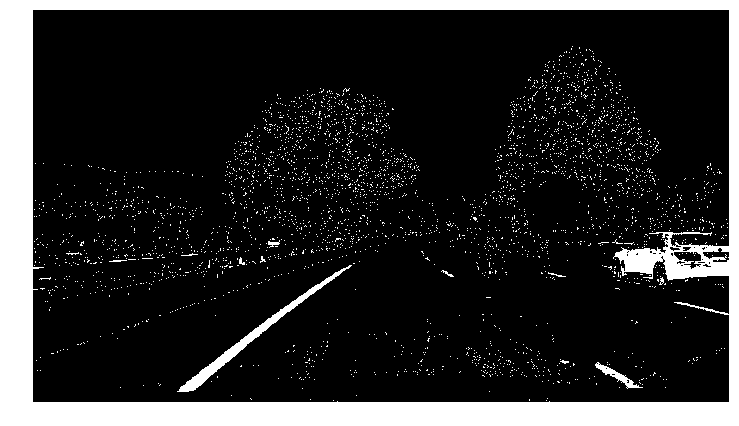

In [19]:
img_binary = thresh_ywx_bgr(undistort(img))
plot_image_GRAY(img_binary)
fig.savefig("output_images/test1_binary.jpg")

# 3. Top Down Perspective Transform

## Perspective Transform Function

In [20]:
def transform(img,src,dst,img_size=img_size):
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size)
    return warped

### Function to Find Source Points

## Perspective Parameters

In [21]:
# set parameters
img_size_warped=(700,2000)

# source
bottom = 657
top = 488

# region mask input
left_bottom = [297, bottom]
right_bottom = [1009, bottom]
left_top = [543, top]
right_top = [748, top]

# destination
# lane dimensions in feet
lane_width = 12
dash_space = 20
dash_line = 10

# destination pixels per foot
pix_per_ft = 20

left_dst = (img_size_warped[0]-lane_width*pix_per_ft)/2
right_dst = (img_size_warped[0]+lane_width*pix_per_ft)/2
top_dst = img_size_warped[1] - (dash_line+dash_space)*pix_per_ft - 20
bottom_dst =  top_dst + (dash_line+dash_space)*pix_per_ft

lane_dst = np.array([[left_dst,bottom_dst],[left_dst,top_dst],
                    [right_dst,top_dst],[right_dst,bottom_dst]], 
                    dtype=np.float32)

lane_src = np.array([[left_bottom],[left_top],[right_top],[right_bottom]], 
                    dtype=np.float32)

The Open CV perspective transform function requires 4 image points source and destination. I used the straight line image from the test images to reference the source points. Since the dimensions of the lane is known, I chose points on the ends of the line dashes. I then calculated the destination points of the warped top down perspective image from the lane dimensions. I assumed that the lane was 12 ft wide, the dash line was 10 ft long, and the space between dashe lines was 20 ft.

In [22]:
def draw_mask(img):
    image_blank = np.copy(img)*0
    image_mask = cv2.line(image_blank,(left_bottom[0],bottom),(left_top[0],top),(0,0,255),4)
    image_mask = cv2.line(image_mask,(left_top[0],top),(right_top[0],top),(0,0,255),4)
    image_mask = cv2.line(image_mask,(right_top[0],top),(right_bottom[0],bottom),(0,0,255),4)
    image_mask = cv2.line(image_mask,(right_bottom[0],bottom),(left_bottom[0],bottom),(0,0,255),4)
    image_mask = cv2.addWeighted(img, 0.8, image_mask, 1, 0)
    return image_mask

In [23]:
def plot_src(img,src):
    plot_image_BGR(img)
    plt.plot(src[0][0][0],src[0][0][1],'.',markersize = 10)
    plt.plot(src[1][0][0],src[1][0][1],'.',markersize = 10)
    plt.plot(src[2][0][0],src[2][0][1],'.',markersize = 10)
    plt.plot(src[3][0][0],src[3][0][1],'.',markersize = 10)

In [24]:
def plot_dst(img,dst,size=100):
    plot_image_BGR(img,size=size)
    plt.plot(dst[0][0],dst[0][1],'.',markersize = 10)
    plt.plot(dst[1][0],dst[1][1],'.',markersize = 10)
    plt.plot(dst[2][0],dst[2][1],'.',markersize = 10)
    plt.plot(dst[3][0],dst[3][1],'.',markersize = 10)

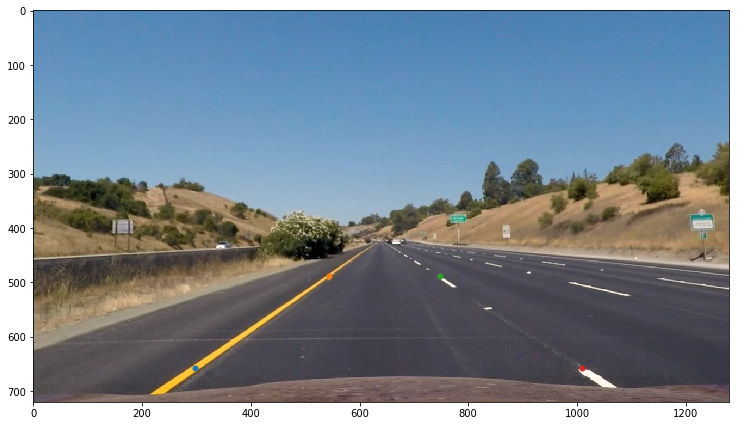

In [25]:
img = cv2.imread('./test_images/straight_lines1.jpg')
undist = undistort(img)
img_undist_mask = draw_mask(undist)
plot_src(undist,lane_src)
plt.axis('on')
fig.savefig("output_images/straight_src.jpg")

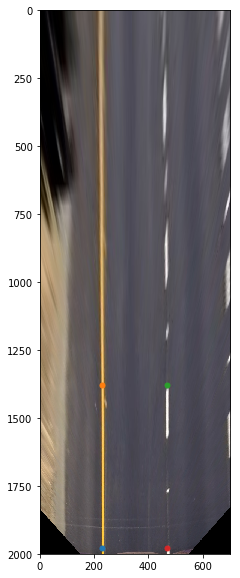

In [26]:
warped = transform(img,lane_src,lane_dst,img_size=img_size_warped)
plot_dst(warped,lane_dst,size=200)
plt.axis('on')
fig.savefig("output_images/straight_dst.jpg")

# 4. Lane Detection and Curve Fitting

Lane Detection uses a sliding window to determine peaks in the x direction of the binary warped image. A histogram of the all the detected points is created in the x direction. The function then centers the window at the histogram peak. The position of each window of the image is fitted to a 2nd order polynomial equation.

In [36]:
def curve_fit_plot(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 15
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 40
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    ploty = np.arange(binary_warped.shape[0])
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Create an output image to draw on and  visualize the result
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Fit a second order polynomial to pixel positions
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    # convertp pixels to ft and m
    left_curverad_ft = left_curverad/pix_per_ft
    left_curverad_ft_m = left_curverad_ft*0.3048

    right_curverad_ft = right_curverad/pix_per_ft
    right_curverad_m = right_curverad_ft*0.3048
    
    # plot curves
    fig= plt.figure(figsize=(16,12))
    global fig
    
    plt.subplot(121)
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.axis('equal')
    plt.xlim(0, binary_warped.shape[1])
    plt.ylim(binary_warped.shape[0], 0)   
        
    plt.subplot(122)
    mark_size = 3
    plt.plot(leftx, lefty, 'o', color='red', markersize=mark_size)
    plt.plot(rightx, righty, 'o', color='blue', markersize=mark_size)
    plt.xlim(0, binary_warped.shape[1])
    plt.ylim(0, binary_warped.shape[0])
    plt.plot(left_fitx, ploty, color='green', linewidth=3)
    plt.plot(right_fitx, ploty, color='green', linewidth=3)
    plt.axis('equal')
    plt.grid('on')
    plt.gca().invert_yaxis() # to visualize as we do the images
    
    return left_curverad_ft_m, right_curverad_m

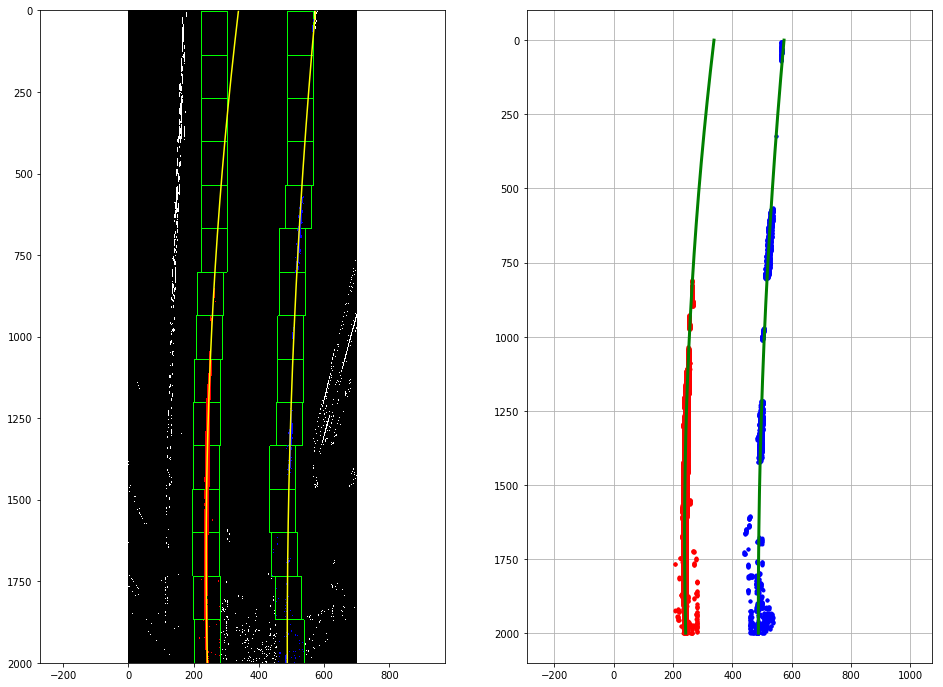

In [42]:
img = cv2.imread('./test_images/test1.jpg')
undist = undistort(img) 
warped = transform(undist,lane_src,lane_dst,img_size=img_size_warped)
binary_warped = thresh_ywx_bgr(warped)
curve_fit_plot(binary_warped)
fig.savefig("output_images/test1_curve_fit.jpg")

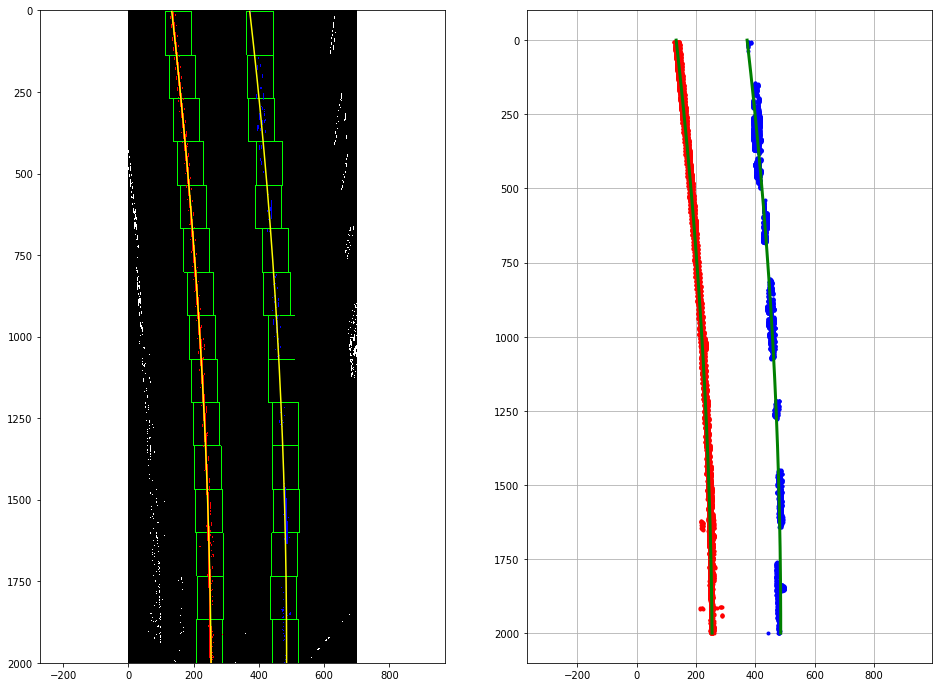

In [43]:
img = cv2.imread('./test_images/test2.jpg')
undist = undistort(img) 
warped = transform(undist,lane_src,lane_dst,img_size=img_size_warped)
binary_warped = thresh_ywx_bgr(warped)
curve_fit_plot(binary_warped)
fig.savefig("output_images/test2_curve_fit.jpg")

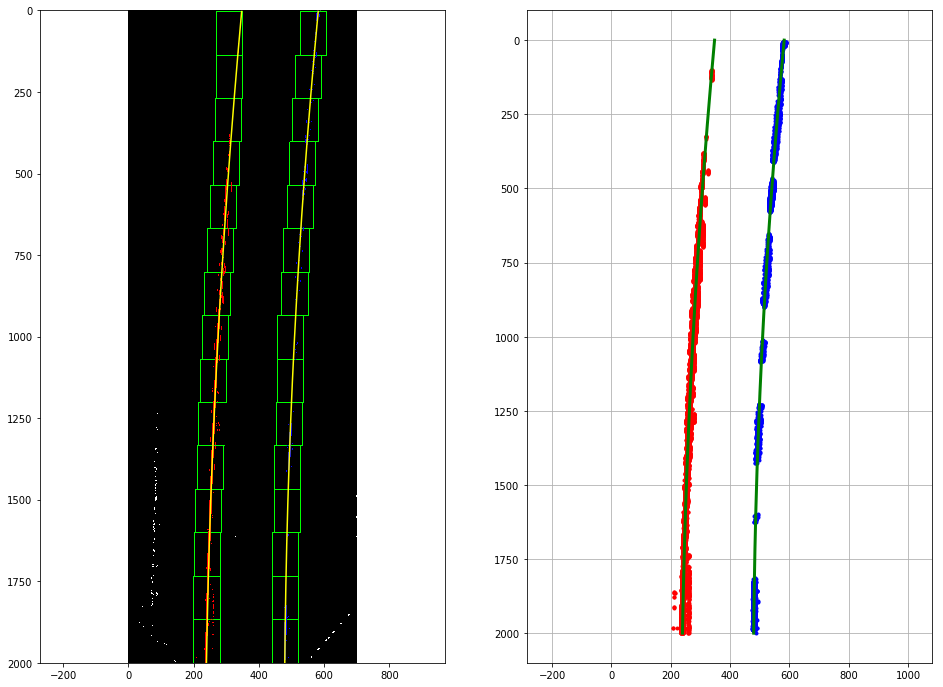

In [44]:
img = cv2.imread('./test_images/test3.jpg')
undist = undistort(img) 
warped = transform(undist,lane_src,lane_dst,img_size=img_size_warped)
binary_warped = thresh_ywx_bgr(warped)
curve_fit_plot(binary_warped)
fig.savefig("output_images/test3_curve_fit.jpg")

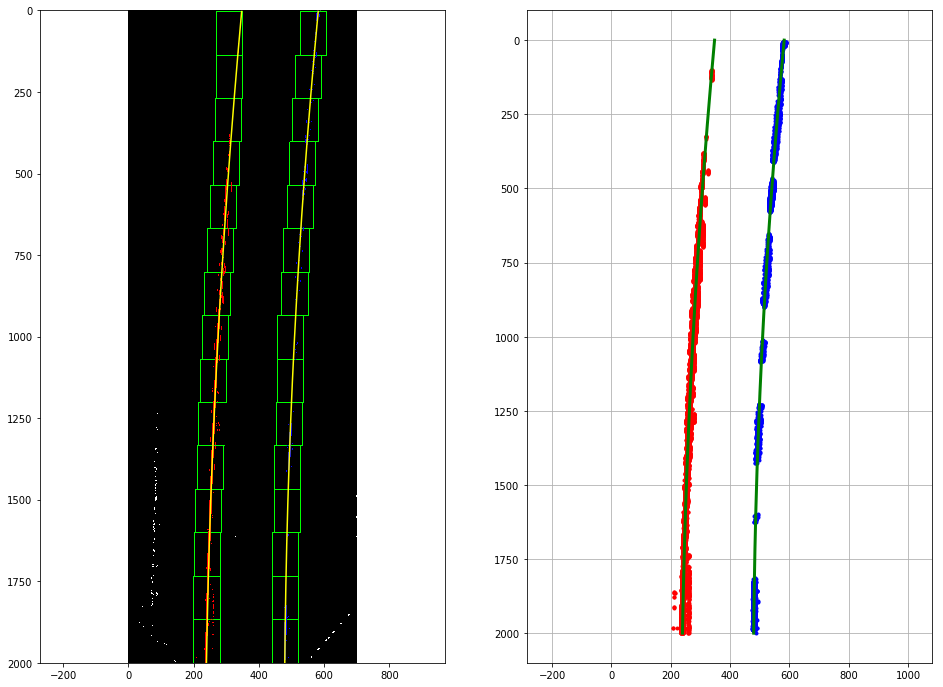

In [39]:
img = cv2.imread('./test_images/test3.jpg')
undist = undistort(img) 
warped = transform(undist,lane_src,lane_dst,img_size=img_size_warped)
binary_warped = thresh_ywx_bgr(warped)
curve_fit_plot(binary_warped)
fig.savefig("output_images/test3_curve_fit.jpg")

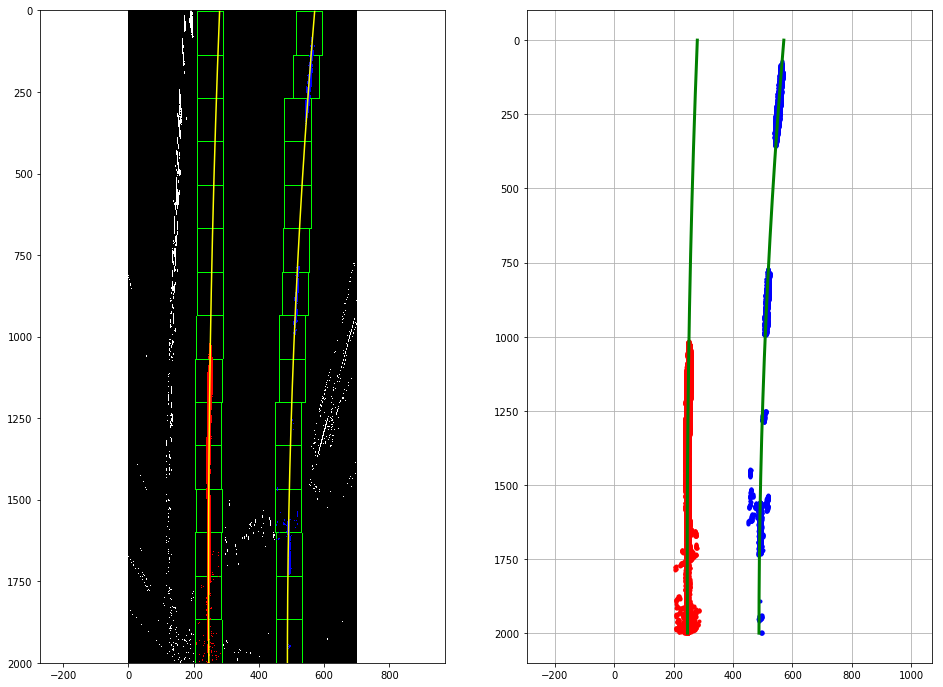

In [40]:
img = cv2.imread('./test_images/test4.jpg')
undist = undistort(img) 
warped = transform(undist,lane_src,lane_dst,img_size=img_size_warped)
binary_warped = thresh_ywx_bgr(warped)
curve_fit_plot(binary_warped)
fig.savefig("output_images/test4_curve_fit.jpg")

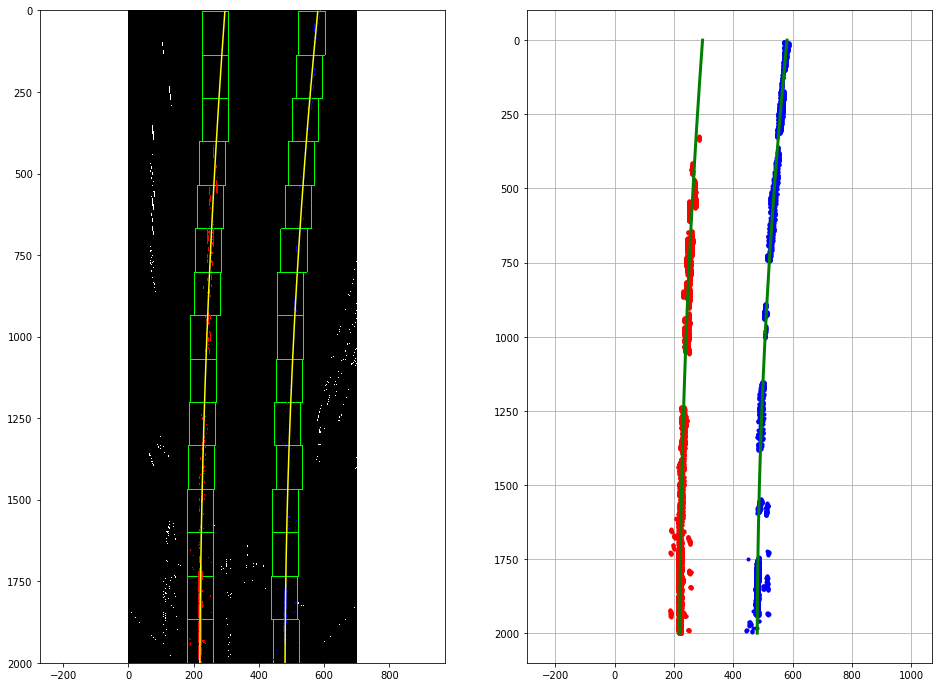

In [45]:
img = cv2.imread('./test_images/test5.jpg')
undist = undistort(img) 
warped = transform(undist,lane_src,lane_dst,img_size=img_size_warped)
binary_warped = thresh_ywx_bgr(warped)
curve_fit_plot(binary_warped)
fig.savefig("output_images/test5_curve_fit.jpg")

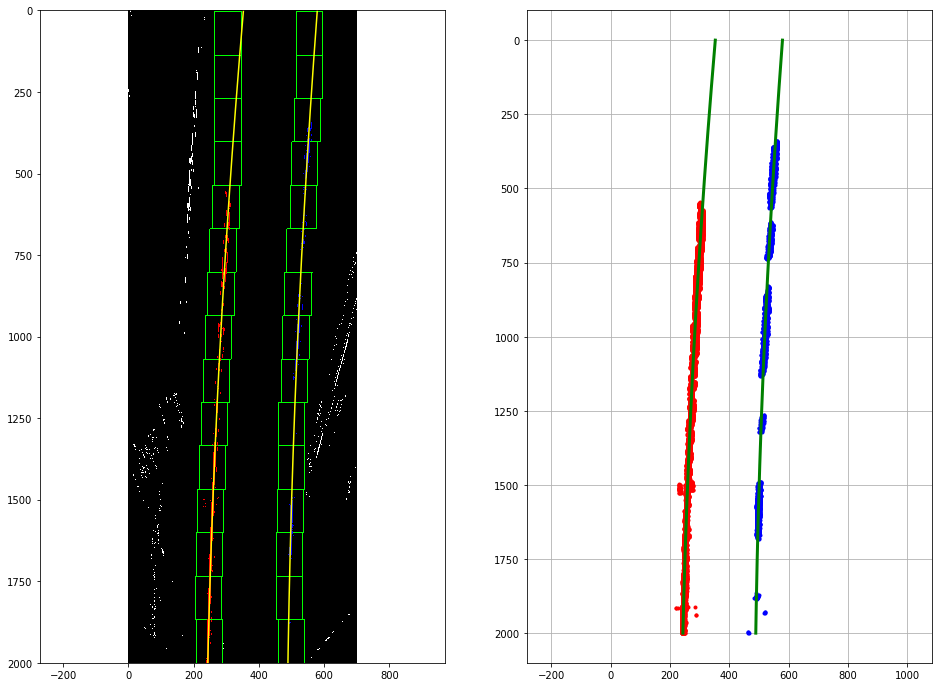

In [46]:
img = cv2.imread('./test_images/test6.jpg')
undist = undistort(img) 
warped = transform(undist,lane_src,lane_dst,img_size=img_size_warped)
binary_warped = thresh_ywx_bgr(warped)
curve_fit_plot(binary_warped)
fig.savefig("output_images/test6_curve_fit.jpg")

# 7. Line Class

The Line Class is required to smooth out lane finding in the video and validate the lane detection. It detects pixels from a binary warped image. It then applies a 2nd order polynomial curve fit to the detected pixels. <br>
<br>
Curves from multiple frames are saved in a buffer for smoothing. This makes detection more robust. Troublesome frames are discarded. A weighted average of this buffer is used to validate the detection of the line from the next frame. If the new line doesn't meet validation requirements, it is not added to the buffer.

In [29]:
def polyfit2_eval(input_array, pfc):
    output_array = pfc[0]*input_array**2 + pfc[1]*input_array + pfc[2]
    return output_array

In [30]:
class Line():
    def __init__(self,buffer_size=5,side = 'left', 
                 img_size_warped=(700,2000),pix_per_ft=20,xdiff=25):
        # length of queue to store data
        self.buffer_size = buffer_size
        #number of fits in buffer
        self.n_buffer = 0
        # flag for lane detection validation
        self.validated = False
        # image size for warped top down perspective
        self.img_size_warped = img_size_warped
        # postion of the vehicle relative to warped image
        self.vehicle_center_x = self.img_size_warped[0]/2
        # pixel to ft conversion for warped image
        self.pix_per_ft = pix_per_ft
        # y input values for polyfit curve equation
        self.pfy = np.arange(self.img_size_warped[1])
        self.bot_y = max(self.pfy)
        self.side = side
        # line difference from avg limit
        self.xdiff = xdiff
        self.histogram = None
        # Updated Values
        #x values for detected line pixels from binary threshold image
        self.points_x = 0
        self.points_y = 0
        #radius of curvature of the line in some units
        self.curvature = 0
        #distance in meters of vehicle center from the line
        self.distance_x = 0
        # x position of detected line at the botom of the detection region
        self.base_x = None
        self.midpoint = np.int(img_size_warped[0]/2)
        
        self.out_img = None
        # polynoimal fit values
        # current polyfit value
        self.pfc_crt = np.zeros(3)
        # average polyfit value in buffer
        self.pfc_avg = np.zeros(3)
        # buffer for polyfit coefficient values
        self.pfc_buffer = deque([],maxlen=buffer_size) 
        # x values of the current polyfit line
        self.pfx_crt = np.array([])
        self.pfx_value_crt = np.array([])
        # buffer for x values from polyfit line
        self.pfx_buffer = deque([],maxlen=buffer_size)
        # average x values in buffer
        self.pfx_avg = np.array([])
        self.pfx_value_avg = np.array([])

        
    # detect line points from binary warped image
    def detect_points(self,img_binary_warped):
        # Choose the number of sliding windows
        nwindows = 15    
        # Set the width of the windows +/- margin
        margin = 30
        # Set minimum number of pixels found to recenter window
        minpix = 40    

        # Set height of windows
        window_height = np.int(self.img_size_warped[1]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = img_binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        #print('detecting line points')
        if self.validated==False:
            #print('searching for line base')
            self.histogram = np.sum(img_binary_warped[int(self.img_size_warped[0]/4):,:], axis=0)
            if self.side == 'left':
                self.base_x = np.argmax(self.histogram[:self.midpoint])
            if self.side == 'right':
                self.base_x = np.argmax(self.histogram[self.midpoint:]) + self.midpoint
        # debug plot
        #self.out_img = np.dstack((img_binary_warped, img_binary_warped, img_binary_warped))*255
        x_current = self.base_x
        # Create empty lists to receive left and right lane pixel indices
        lane_inds = []
        
        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = self.img_size_warped[1] - (window+1)*window_height
            win_y_high = self.img_size_warped[1] - window*window_height
            win_x_low = x_current - margin
            win_x_high = x_current + margin
            # Draw the windows on the visualization image
            #cv2.rectangle(self.out_img,(win_x_low,win_y_low),(win_x_high,win_y_high),(0,255,0), 2)
            
            # Identify the nonzero pixels in x and y within the window
            good_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_x_low) &  (nonzerox < win_x_high)).nonzero()[0]

            # Append these indices to the lists
            lane_inds.append(good_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_inds) > minpix:
                x_current = np.int(np.mean(nonzerox[good_inds]))

        # Concatenate the arrays of indices
        lane_inds = np.concatenate(lane_inds)
        # self.out_img[nonzeroy[lane_inds], nonzerox[lane_inds]] = [255, 0, 0]
        
        # Extract left and right line pixel positions
        self.points_x = nonzerox[lane_inds]
        self.points_y = nonzeroy[lane_inds] 
        return
    
    def set_curvature(self):
        self.curvature = ((1 + (2*self.pfc_avg[0]*self.bot_y + self.pfc_avg[1])**2)**1.5) \
                             /np.absolute(2*self.pfc_avg[0])
        # convert pixels to ft to m
        self.curvature *= 1/pix_per_ft/3.28084

    # validate line detection
    def validate_lane(self):
        # check if lane is too far away
        if (abs(self.pfx_value_crt - self.pfx_value_avg) > self.xdiff):
            print('line failed validation')
            self.validated=False
        else:
            self.validated = True   
        return
    
    
    def update(self,img_binary_warped):
        self.detect_points(img_binary_warped)
        # calculate polyfit coefficients
        self.pfc_crt = np.polyfit(self.points_y, self.points_x, 2)
        # evaluate current polyfit curve to caluclate x points
        self.pfx_crt = polyfit2_eval(self.pfy,self.pfc_crt)
        self.pfx_value_crt = np.mean(self.pfx_crt)
        
        # validate current lane detection
        self.validate_lane()
        if self.validated:
            # add current values to buffer
            self.pfx_buffer.appendleft(self.pfx_crt)
            self.pfc_buffer.appendleft(self.pfc_crt)
            # set current buffer size
            self.n_buffer = len(self.pfc_buffer)
            # remove oldest values from buffer if buffer size exceeded
            if self.n_buffer > self.buffer_size:
                self.pfx_buffer.pop()
                self.pfc_buffer.pop()
            # average values for smoothing
            # exponentially weighted average
            x=np.linspace(1,self.n_buffer,self.n_buffer)
            self.pfc_avg = np.average(self.pfc_buffer,axis=0,weights=np.exp(-1.*x))
            self.pfx_avg = polyfit2_eval(self.pfy,self.pfc_avg)
            # average x value for line, used for validation
            self.pfx_value_avg = np.mean(self.pfx_avg)
            self.base_x = polyfit2_eval(self.bot_y,self.pfc_avg)
            # convert pixels to ft to m
            self.distance_x = (self.base_x - self.vehicle_center_x)
            self.distance_x *= 1/pix_per_ft/3.28084
            self.set_curvature()
            
        return

draw detected lane lines on undistorted image

In [31]:
def draw_lane(img_undist, img_binary_warped, pfx_left, pfx_right, pfy, lane_src, lane_dst):

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(img_binary_warped).astype(np.uint8)
    lanes_warped = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    points_left = np.array([np.transpose(np.vstack([pfx_left, pfy]))])
    points_right = np.array([np.flipud(np.transpose(np.vstack([pfx_right, pfy])))])
    points = np.hstack((points_left, points_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(lanes_warped, np.int_([points]), (0,255, 0))
    cv2.polylines(lanes_warped, np.int32([points_left]), isClosed=False, color=(0,0,255), thickness=15)
    cv2.polylines(lanes_warped, np.int32([points_right]), isClosed=False, color=(255,0,0), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    M = cv2.getPerspectiveTransform(lane_dst, lane_src)
    lanes_unwarped = cv2.warpPerspective(lanes_warped, M, img_size)
    # Combine the result with the original image
    img_lanes = cv2.addWeighted(img_undist, 1, lanes_unwarped, 0.2, 0)
    return img_lanes


image processing function runs the entire lane dection pipeline

In [32]:
def process_ywx_rgb(img):
    global right_lane
    global left_lane
    
    img_undist = undistort(img) 
    img_warped = transform(img_undist,lane_src,lane_dst,img_size_warped)
    img_binary_warped = thresh_ywx_rgb(img_warped)
    
    left_lane.update(img_binary_warped)
    right_lane.update(img_binary_warped)
    # debug
    # plot_image_GRAY(img_binary_warped)
    img_lanes = draw_lane(img_undist, img_binary_warped, left_lane.pfx_avg, \
                          right_lane.pfx_avg, right_lane.pfy, lane_src, lane_dst)
    # img_lanes = img_binary_warped
    vehicle_position = round((left_lane.distance_x + right_lane.distance_x),3)
    radius_of_curvature = round((left_lane.curvature + right_lane.curvature)/2,0)
    str_vp = str('Distance from Lane Center: '+str(vehicle_position) + 'm')
    str_rc = str('Radius of Curvature: '+str(radius_of_curvature) + 'm')
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img_lanes,str_vp,(430,630), font, 1,(255,0,0),2,cv2.LINE_AA)
    cv2.putText(img_lanes,str_rc,(430,670), font, 1,(255,0,0),2,cv2.LINE_AA)
    return img_lanes

In [33]:
def process_ywx_bgr(img):
    global right_lane
    global left_lane
    
    img_undist = undistort(img) 
    img_warped = transform(img_undist,lane_src,lane_dst,img_size_warped)
    img_binary_warped = thresh_ywx_bgr(img_warped)
    
    left_lane.update(img_binary_warped)
    right_lane.update(img_binary_warped)
    # debug
    # plot_image_GRAY(img_binary_warped)
    img_lanes = draw_lane(img_undist, img_binary_warped, left_lane.pfx_avg, \
                          right_lane.pfx_avg, right_lane.pfy, lane_src, lane_dst)
    # img_lanes = img_binary_warped
    vehicle_position = round((left_lane.distance_x + right_lane.distance_x),3)
    radius_of_curvature = round((left_lane.curvature + right_lane.curvature)/2,0)
    str_vp = str('Distance from Lane Center: '+str(vehicle_position) + 'm')
    str_rc = str('Radius of Curvature: '+str(radius_of_curvature) + 'm')
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img_lanes,str_vp,(430,630), font, 1,(255,0,0),2,cv2.LINE_AA)
    cv2.putText(img_lanes,str_rc,(430,670), font, 1,(255,0,0),2,cv2.LINE_AA)
    return img_lanes

# 6. Lane-Detected Image

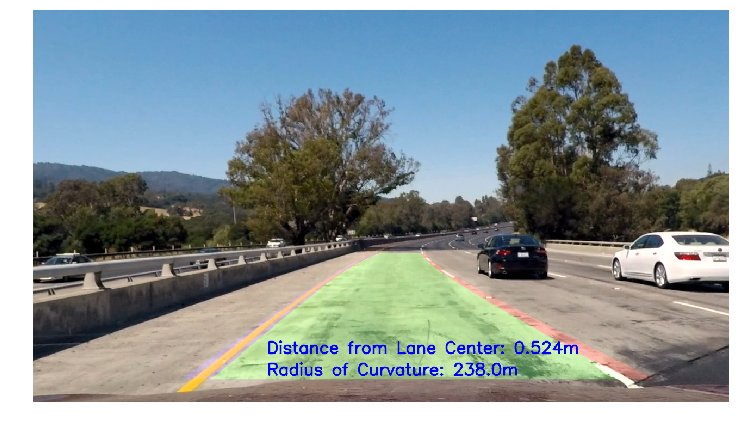

In [34]:
right_lane = Line()
left_lane = Line(side='right')
img = cv2.imread('./test_images/test1.jpg')
img_lanes = process_ywx_bgr(img)
plot_image_BGR(img_lanes,size=100)
fig.savefig("output_images/test1_detected.jpg")

# 7. Output Video

In [35]:
# average pixel difference between average and current detected line
# used for lane detection validation
# smaller values are more strict
xdiff = 15
# buffer size used for average detected line
buffer_size = 5
left_lane = Line(xdiff=xdiff,buffer_size=buffer_size)
right_lane = Line(xdiff=xdiff,buffer_size=buffer_size,side='right')
video_input = VideoFileClip('project_video.mp4')
sub = video_input.subclip(20,30)
video_output = './video_output/project_video_process_full.mp4'
image_output = video_input.fl_image(process_ywx_rgb)
%time image_output.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video ./video_output/project_video_ywx_sub_w30_15_full.mp4
[MoviePy] Writing video ./video_output/project_video_ywx_sub_w30_15_full.mp4


 44%|██████████████████████████▏                                | 559/1261 [01:46<02:11,  5.34it/s]

line failed validation
line failed validation


 44%|██████████████████████████▏                                | 560/1261 [01:46<02:10,  5.38it/s]

line failed validation
line failed validation


 44%|██████████████████████████▏                                | 561/1261 [01:46<02:14,  5.20it/s]

line failed validation
line failed validation


 45%|██████████████████████████▎                                | 562/1261 [01:47<02:17,  5.08it/s]

line failed validation


 49%|█████████████████████████████▏                             | 624/1261 [01:58<01:56,  5.47it/s]

line failed validation


 50%|█████████████████████████████▏                             | 625/1261 [01:58<01:58,  5.37it/s]

line failed validation


 50%|█████████████████████████████▎                             | 626/1261 [01:58<01:57,  5.40it/s]

line failed validation


 50%|█████████████████████████████▎                             | 627/1261 [01:59<01:59,  5.31it/s]

line failed validation


 50%|█████████████████████████████▍                             | 628/1261 [01:59<02:00,  5.27it/s]

line failed validation


 50%|█████████████████████████████▊                             | 636/1261 [02:00<01:54,  5.46it/s]

line failed validation


 51%|█████████████████████████████▊                             | 637/1261 [02:00<01:51,  5.59it/s]

line failed validation


 80%|██████████████████████████████████████████████▏           | 1005/1261 [03:09<00:54,  4.73it/s]

line failed validation


 80%|██████████████████████████████████████████████▎           | 1006/1261 [03:09<00:55,  4.56it/s]

line failed validation


 80%|██████████████████████████████████████████████▎           | 1007/1261 [03:09<00:56,  4.53it/s]

line failed validation


 80%|██████████████████████████████████████████████▎           | 1008/1261 [03:09<00:55,  4.54it/s]

line failed validation


 80%|██████████████████████████████████████████████▍           | 1009/1261 [03:10<00:56,  4.48it/s]

line failed validation


 80%|██████████████████████████████████████████████▍           | 1010/1261 [03:10<00:56,  4.41it/s]

line failed validation


100%|█████████████████████████████████████████████████████████▉| 1260/1261 [04:00<00:00,  5.51it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./video_output/project_video_ywx_sub_w30_15_full.mp4 

Wall time: 4min
